# Implementation using PyTorch NN

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import random

In [8]:
# read in words
words = open('names.txt', 'r').read().splitlines()
# shuffle up the words
random.seed(42)
random.shuffle(words)
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [51]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [52]:
# Defining the NN 

n_embd = 10 # number of dimensions in the character embeddings
n_hidden = 100 # number of neurons in a hidden layer

model = torch.nn.Sequential(
    torch.nn.Embedding(vocab_size, n_embd),
    torch.nn.Flatten(),
    torch.nn.Linear(n_embd * block_size, n_hidden, bias=False), torch.nn.BatchNorm1d(n_hidden), torch.nn.Tanh(),
    torch.nn.Linear(n_hidden, n_hidden, bias=False), torch.nn.BatchNorm1d(n_hidden), torch.nn.Tanh(),
    torch.nn.Linear(n_hidden, vocab_size)
)

sum(p.nelement() for p in model.parameters())

21397

In [53]:
n_steps = 200000
batch_size = 32
lossi = []

for i in range(n_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    logits = model(Xb)

    # Loss
    loss = F.cross_entropy(logits, Yb)
    
    # Backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in model.parameters():
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d} /{n_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 / 200000: 3.4362
  10000 / 200000: 2.0477
  20000 / 200000: 1.9263
  30000 / 200000: 1.6227
  40000 / 200000: 1.8152
  50000 / 200000: 1.8642
  60000 / 200000: 1.9910
  70000 / 200000: 1.7276
  80000 / 200000: 2.3470
  90000 / 200000: 1.8395
 100000 / 200000: 2.0605
 110000 / 200000: 2.0377
 120000 / 200000: 1.4708
 130000 / 200000: 2.1613
 140000 / 200000: 2.2262
 150000 / 200000: 1.7572
 160000 / 200000: 2.2245
 170000 / 200000: 2.3912
 180000 / 200000: 1.9936
 190000 / 200000: 2.1376


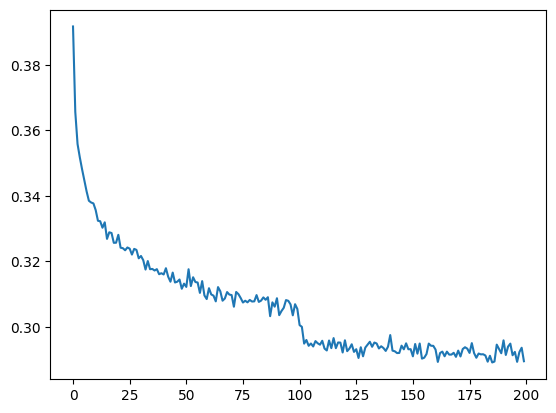

In [55]:
plt.plot(torch
 .tensor(lossi)
 .view(-1, 1000) # each row is a consecutive 1000, that we can take a mean of
 .mean(1))

In [84]:
model.eval()

Sequential(
  (0): Embedding(27, 10)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=80, out_features=100, bias=False)
  (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Tanh()
  (5): Linear(in_features=100, out_features=100, bias=False)
  (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Tanh()
  (8): Linear(in_features=100, out_features=27, bias=True)
)

In [85]:
# evaluate the loss (entire dataset, no batching)
@torch.no_grad
def split_loss(split):
    X, Y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9286613464355469
val 2.024355411529541


In [93]:
# sample from the model
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the NN
        logits = model(torch.tensor([context]))
        prob = F.softmax(logits, dim=1)

        # sample from distribution
        ix = torch.multinomial(prob, num_samples=1, replacement=True).item()
        
        # shift context window and track samples
        context = context[1:] + [ix]
        out.append(itos[ix])
        # break if we sample the ending character
        if ix == 0:
            break
    print(''.join(out))

pebonia.
jamilo.
renna.
naiden.
reinn.
karic.
eliany.
aiyana.
landy.
sakeas.
